In [1]:
import xarray as xr
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.preprocessing import StandardScaler
from temp_clustering import cluster_temp_diff
from settings import path_data

## Import data set and preprocess

In [2]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset(path_data / 'T2m_R2_ym_1stMill.nc')

In [3]:
def smooth_butter(data, order):
    b, a = signal.butter(order, 0.125)
    y = signal.filtfilt(b, a, data, padlen=150)
    return y

In [4]:
# Dataset for Solar Forcing
df_solar = {'time':ds_solar.time.values, 'TSI':ds_solar.TSI.values.flatten()}

# Dataset for volcanic forcing
df_volc = {'time':ds_volc.time.values, 'AOD':ds_volc.AOD.values.flatten()}

# Dataset for R1
df_R1 = {'time': ds_temp_r1.time.values, 'lon':ds_temp_r1.lon.values, 'lat': ds_temp_r1.lat.values, 'T2m':ds_temp_r1.T2m.values}

# Dataset for R2
df_R2 = {'time': ds_temp_r2.time.values, 'lon':ds_temp_r2.lon.values, 'lat': ds_temp_r2.lat.values, 'T2m':ds_temp_r2.T2m.values}

In [5]:
for key in df_solar:
    print("Solar Forcing: Key = {}, shape = {}".format(key, df_solar[key].shape)) 
print('')
for key in df_volc:
    print("Volcanic Forcing: Key = {}, shape = {}".format(key, df_volc[key].shape))
print('')
for key in df_R1:
    print("Sim R1: Key = {}, shape = {}".format(key, df_R1[key].shape))
print('')
for key in df_R2:
    print("Sim R2: Key = {}, shape = {}".format(key, df_R2[key].shape))

Solar Forcing: Key = time, shape = (999,)
Solar Forcing: Key = TSI, shape = (999,)

Volcanic Forcing: Key = time, shape = (999,)
Volcanic Forcing: Key = AOD, shape = (999,)

Sim R1: Key = time, shape = (999,)
Sim R1: Key = lon, shape = (192,)
Sim R1: Key = lat, shape = (96,)
Sim R1: Key = T2m, shape = (999, 96, 192)

Sim R2: Key = time, shape = (999,)
Sim R2: Key = lon, shape = (192,)
Sim R2: Key = lat, shape = (96,)
Sim R2: Key = T2m, shape = (999, 96, 192)


## Visualize

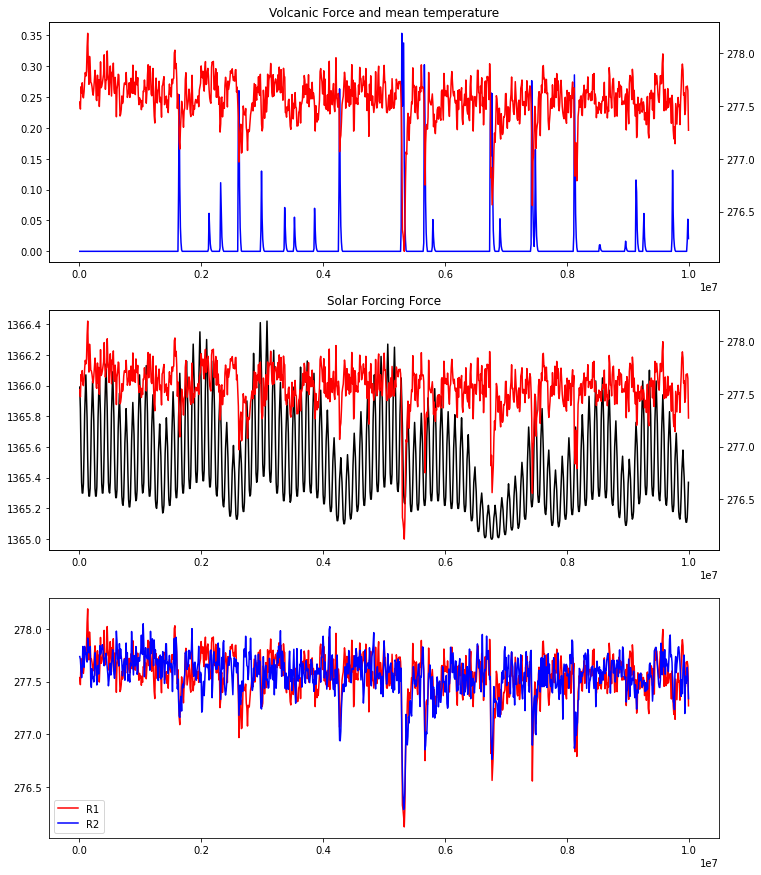

In [6]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
ax[0].plot(df_volc['time'], df_volc['AOD'], 'b', label = 'Volcanic force')
ax[0].set_title('Volcanic Force and mean temperature')
ax2 = ax[0].twinx()
ax2.plot(df_R1['time'], np.mean(np.mean(df_R1['T2m'],axis = 2),1), 'r', label = 'mean tep');

ax[1].plot(df_solar['time'],df_solar['TSI'], 'k', label = 'Solar force');
ax[1].set_title('Solar Forcing Force')
ax3 = ax[1].twinx()
ax3.plot(df_R1['time'], np.mean(np.mean(df_R1['T2m'],axis = 2),1), 'r', label = 'mean temp');

ax[2].plot(df_R1['time'], np.mean(np.mean(df_R1['T2m'],axis = 2),1), 'r', label = 'R1')
ax[2].plot(df_R2['time'], np.mean(np.mean(df_R2['T2m'],axis = 2),1), 'b', label = 'R2')
ax[2].legend();

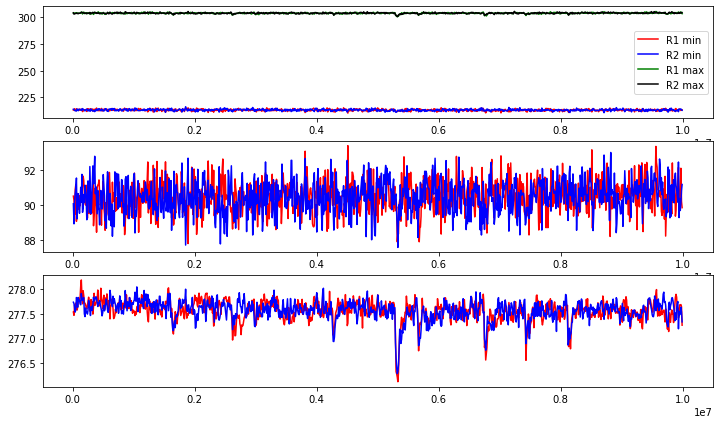

In [7]:
fig, ax = plt.subplots(3,1, figsize=(12,7))
ax[0].plot(df_R1['time'], np.min(np.min(df_R1['T2m'],axis = 2),1), 'r', label = 'R1 min')
ax[0].plot(df_R2['time'], np.min(np.min(df_R2['T2m'],axis = 2),1), 'b', label = 'R2 min')

ax[0].plot(df_R1['time'], np.max(np.max(df_R1['T2m'],axis = 2),1), 'g', label = 'R1 max')
ax[0].plot(df_R2['time'], np.max(np.max(df_R2['T2m'],axis = 2),1), 'k', label = 'R2 max')

ax[1].plot(df_R1['time'], np.max(np.max(df_R1['T2m'],axis = 2),1) - np.min(np.min(df_R1['T2m'],axis = 2),1), 'r', label = 'R1 min')
ax[1].plot(df_R2['time'], np.max(np.max(df_R2['T2m'],axis = 2),1) - np.min(np.min(df_R2['T2m'],axis = 2),1), 'b', label = 'R2 min')

ax[2].plot(df_R1['time'], np.mean(np.mean(df_R1['T2m'],axis = 2),1), 'r', label = 'R1')
ax[2].plot(df_R2['time'], np.mean(np.mean(df_R2['T2m'],axis = 2),1), 'b', label = 'R2')
ax[0].legend()

In [8]:
df_volcBool = df_volc['AOD'].copy()
df_volcBool[df_volcBool > 0] = 1

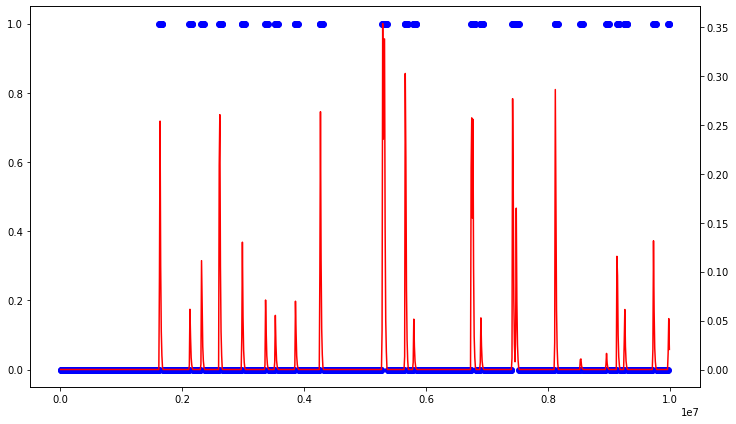

In [9]:
fig, ax = plt.subplots(1,1, figsize = (12,7))
ax.plot(df_volc['time'], df_volcBool, 'ob')
ax2 = ax.twinx()
ax2.plot(df_volc['time'], df_volc['AOD'], 'r')

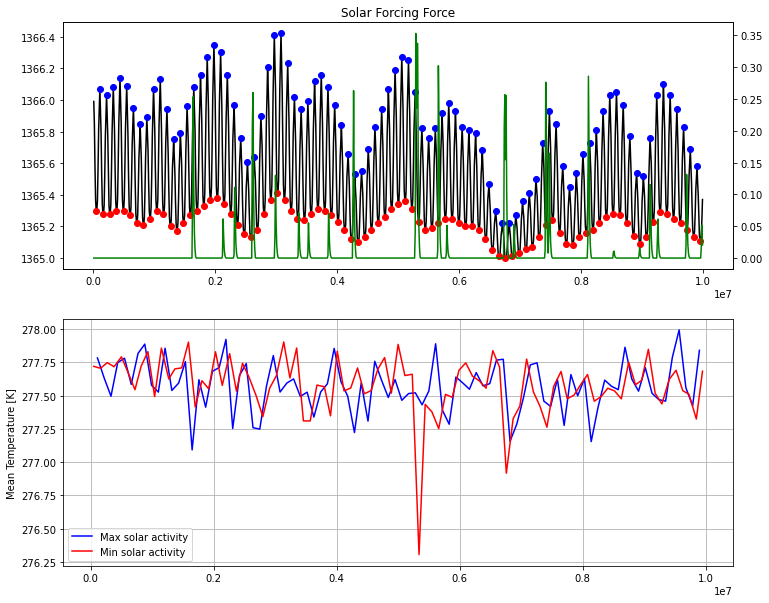

In [10]:
####################
## Minimum and Maximum of solar activity
# Maximum peaks
solar_maxX = df_solar['time'][signal.find_peaks(df_solar['TSI'])[0]]
solar_maxY = df_solar['TSI'][signal.find_peaks(df_solar['TSI'])[0]]
# minimum peaks
solar_minX = df_solar['time'][signal.find_peaks(-1*df_solar['TSI'])[0]]
solar_minY = df_solar['TSI'][signal.find_peaks(-1*df_solar['TSI'])[0]]

#######################
## Visualize
fig, (ax,ax2) = plt.subplots(2,1, figsize =(12,10))
ax.plot(df_solar['time'], df_solar['TSI'], 'k', label = 'Solar force');
ax.set_title('Solar Forcing Force')
ax.plot(solar_maxX,solar_maxY,'ob')
ax.plot(solar_minX,solar_minY,'or')

ax3 = ax.twinx()

#ax3.plot(df_R1['time'], np.mean(np.mean(df_R1['T2m'],axis = 2),1)-277.15, 'r', label = 'mean temp');
ax3.plot(df_volc['time'], df_volc['AOD'], 'g')

ax2.plot(solar_maxX, np.mean(np.mean(df_R1['T2m'][signal.find_peaks(df_solar['TSI'])[0]],axis = 2),1), 'b', label = 'Max solar activity');
ax2.plot(solar_minX, np.mean(np.mean(df_R1['T2m'][signal.find_peaks(-1*df_solar['TSI'])[0]],axis = 2),1), 'r', label = 'Min solar activity');
ax2.set_ylabel('Mean Temperature [K]')
ax2.legend()
ax2.grid()

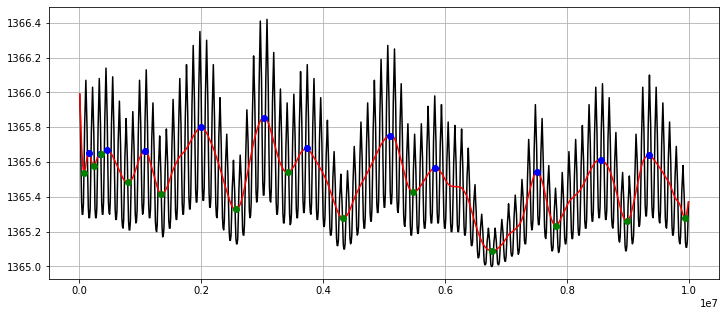

In [11]:
order = 8
smooth_solar = smooth_butter(df_solar['TSI'],order)
solar_smooth_maxX = df_solar['time'][signal.find_peaks(smooth_solar)[0]]
solar_smooth_maxY = smooth_solar[signal.find_peaks(smooth_butter(df_solar['TSI'],order))[0]]

solar_smooth_minX = df_solar['time'][signal.find_peaks(-1*smooth_solar)[0]]
solar_smooth_minY = smooth_solar[signal.find_peaks(smooth_butter(-1*df_solar['TSI'],order))[0]]

fig, ax = plt.subplots(1,1, figsize =(12,5))
ax.plot(df_solar['time'], df_solar['TSI'], 'k', label = 'Solar force');
ax.plot(df_solar['time'], smooth_butter(df_solar['TSI'],8), 'r', label = 'Solar force');
ax.plot(solar_smooth_maxX, solar_smooth_maxY, 'ob')
ax.plot(solar_smooth_minX, solar_smooth_minY, 'og')
ax.grid();

## Tensorflow model
(100,10,96,192)

In [620]:
def reshape_data_window_approach(df, output, window_size, 
                                 step_size, target_size, BoolVolcano):
    ######################
    ## INPUT:
    ##        df_input = Input data
    ##        output = Label data
    ##        window_size = length of the time window
    ##        step_size = step size of the window
    ##        target_size = amount of to be predicted values
    ##        BoolVolcano = data to be removed from Input data
    ##
    ## Output:
    ##        ndarray np.array(data) = windowed input data
    ##        ndarray np.array(labels) = desired output data
    #####################
    labels = []
    data = []
    
    final_idx = df.shape[0] - window_size
    for i in range(0, df.shape[0], step_size):
        if i+window_size <= df.shape[0]:
            idx = range(i,i+window_size)
            if all(BoolVolcano[i+window_size:i+window_size+target_size]):
                temp_difference = df[idx,:,:] - np.mean(df,axis = 0)[None]
                data.append(np.transpose(temp_difference, (1,2,0)))
                labels.append(np.reshape(output[idx],(window_size)))
    return np.array(data), np.array(labels)

In [647]:
x_tmp, y_tmp = reshape_data_window_approach(df_R1['T2m'],
                                   smooth_butter(df_solar['TSI'],8), 
                                   10, 
                                   2,
                                   10,
                                   [True]*df_R1['T2m'].shape[0])

In [648]:
print("Input data shape = {}, Label shape = {}".format(x_tmp.shape, y_tmp.shape))

Input data shape = (495, 96, 192, 10), Label shape = (495, 10)


Text(0.5, 1.0, 'Label data seperated')

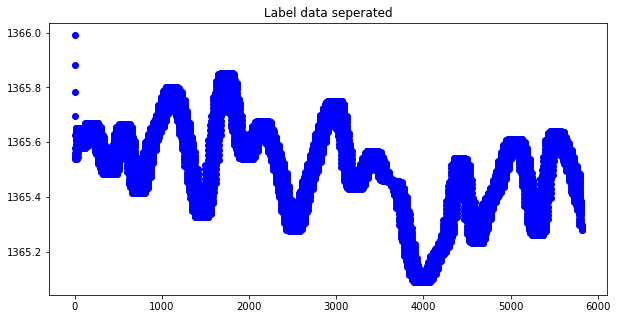

In [463]:
y_true = np.zeros(shape = (int(y_tmp.shape[0]*y_tmp.shape[1])))
fig, ax = plt.subplots(1,1, figsize =(10,5))
for i, val in enumerate(y_tmp):
    y_true[range(i*y_tmp.shape[1],(i+1)*y_tmp.shape[1])] = val
    ax.plot(range(i*y_tmp.shape[1],(i+1)*y_tmp.shape[1]), val, 'ob')
ax.set_title('Label data seperated')

In [649]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=x_tmp.shape[1:], name = 'Inp'))
model.add(layers.MaxPooling2D((4,4)))
model.add(layers.Conv2D(32, (3,3), activation='relu', name = 'C1'))
model.add(layers.MaxPooling2D((4,4)))
model.add(layers.Conv2D(16, (3,3), activation='relu', name = 'C2'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', name = 'D1'))
model.add(layers.Dense(y_tmp.shape[-1],activation = 'linear', name = 'Out'))

model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inp (Conv2D)                 (None, 94, 190, 16)       1456      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 23, 47, 16)        0         
_________________________________________________________________
C1 (Conv2D)                  (None, 21, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 5, 11, 32)         0         
_________________________________________________________________
C2 (Conv2D)                  (None, 3, 9, 16)          4624      
_________________________________________________________________
flatten_33 (Flatten)         (None, 432)               0         
_________________________________________________________________
D1 (Dense)                   (None, 64)              

In [651]:
## preprocess the data --> Standardization
scaler = StandardScaler()
X_scaled = x_tmp#scaler.fit_transform(x_tmp.reshape(-1, x_tmp.shape[-1])).reshape(x_tmp.shape)
y_scaled = y_tmp#scaler.fit_transform(y_tmp.reshape(-1, y_tmp.shape[-1])).reshape(y_tmp.shape)

In [661]:
#model.compile(optimizer='adam',loss=tf.keras.losses.MSE(x_tmp, y_tmp), metrics=['loss'])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

history = model.fit(X_scaled, y_scaled, epochs=10, shuffle = True, batch_size = 4)#, 
                    #validation_data=(df_R1['T2m'][700:], df_volcBool[700:]))

Train on 495 samples
Epoch 1/10
495/495 [==============================] - 16s 33ms/sample - loss: 33.8765
Epoch 2/10
495/495 [==============================] - 15s 31ms/sample - loss: 26.9978
Epoch 3/10
495/495 [==============================] - 14s 28ms/sample - loss: 25.3790
Epoch 4/10
495/495 [==============================] - 11s 23ms/sample - loss: 24.7470
Epoch 5/10
495/495 [==============================] - 12s 25ms/sample - loss: 31.7641
Epoch 6/10
495/495 [==============================] - 12s 25ms/sample - loss: 28.7397
Epoch 7/10
495/495 [==============================] - 13s 26ms/sample - loss: 25.5707
Epoch 8/10
495/495 [==============================] - 13s 25ms/sample - loss: 22.9525
Epoch 9/10
495/495 [==============================] - 13s 25ms/sample - loss: 25.3704
Epoch 10/10
495/495 [==============================] - 12s 25ms/sample - loss: 25.0989


In [658]:
preds = model.predict(X_scaled)

In [501]:
y_pred = np.zeros(shape = (int(preds.shape[0]*preds.shape[1])))
for i, val in enumerate(preds):
    y_pred[range(i*preds.shape[1],(i+1)*preds.shape[1])] = val
    
y_true = np.zeros(shape = (int(y_scaled.shape[0]*y_scaled.shape[1])))
for i, val in enumerate(y_scaled):
    y_true[range(i*y_scaled.shape[1],(i+1)*y_scaled.shape[1])] = val


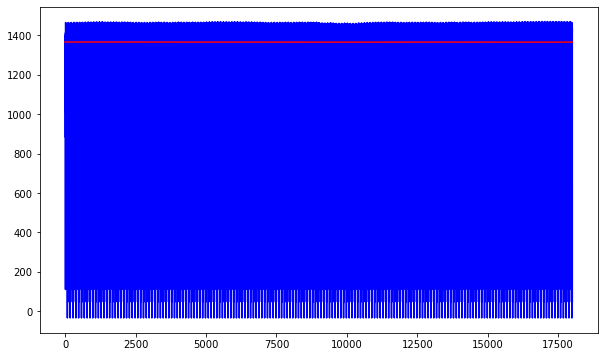

In [502]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(y_pred[:], 'b')
ax.plot(y_true, 'r')
#preds

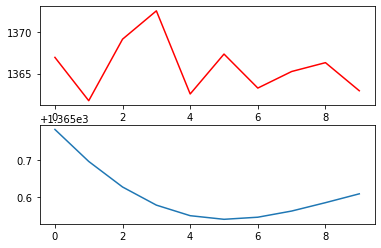

In [660]:
fig,ax = plt.subplots(2,1,figsize = (6,4))
ax[0].plot(preds[1], 'r')
ax[1].plot(y_scaled[1])

In [455]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

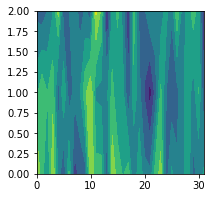

In [519]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
ax.contourf(np.mean(weights[0][0][:,:,0], axis = 0))

## KNN

In [521]:
from sklearn.cluster import KMeans

In [524]:
kmeans = KMeans(n_clusters=10, random_state=0)

In [534]:
x, y = df_R1['T2m'][0].shape
kmeans.fit(df_R1['T2m'][0])

cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

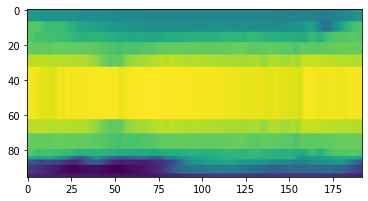

In [536]:
plt.imshow(cluster_centers[cluster_labels].reshape(x, y))

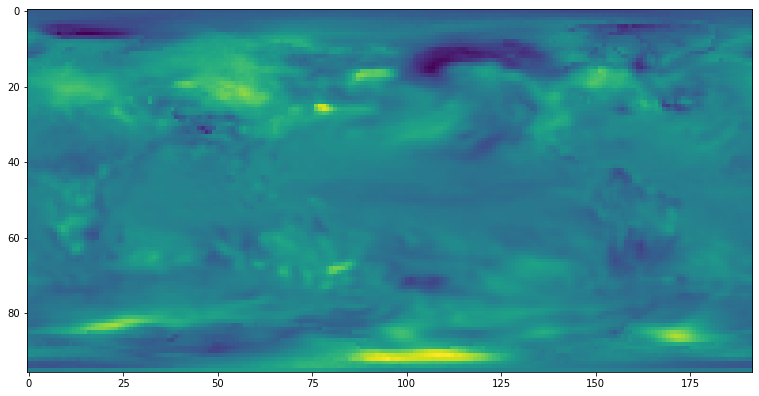

In [577]:
fig, ax = plt.subplots(1,1, figsize = (13,13))
#ax.imshow(df_R1['T2m'][0] - cluster_centers[cluster_labels].reshape(x, y))
ax.imshow(df_R1['T2m'][22] - np.mean(df_R1['T2m'],axis = 0))

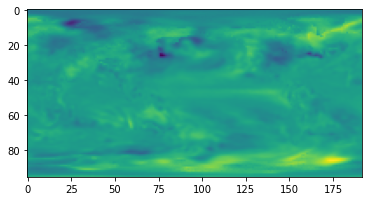

In [604]:
plt.imshow(n[2,:,:])

In [603]:
n = df_R1['T2m'][range(0,10,1),:,:] - np.mean(df_R1['T2m'],axis = 0)[None]
n.shape

(10, 96, 192)

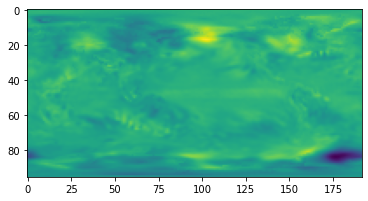

In [622]:
plt.imshow(x_tmp[2,:,:,0])

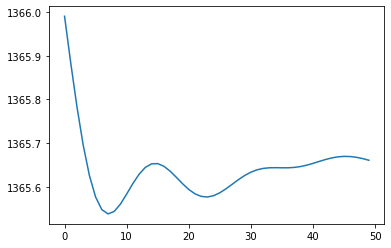

In [624]:
plt.plot(y_tmp[0])